In [1]:
from lusidtools.jupyter_tools import toggle_code

"""Interest Rate Swap Valuation

Demonstrates pricing of an Interes Rate Swap based on a user defined Instrument.

Attributes
----------
instruments
aggregation
market data store
results store
quotes
"""

toggle_code("Hide docstring")

## Interest Rate Swap Valuation 

This notebook illustrates construction of an _Interest Rate Swap_ and how its underlying defintions can be setup using the LUSID API, as well as how valuations and aggregations can be run using different endpoints. For valuations, we will be looking to use the 'Discounting' model, which uses a set of user-defined curves to discount each cash flow.

The example instrument we will be constructing is a vanilla interest rate swap with the following parameters:

    -  Coupon Rate: 1%
    -  Start Date: 01/10/2019
    -  Maturity: 10Y
    -  Currency: EUR
    -  Payment Frequency: 6M
    -  Index: Euribor 6M
    -  Side: Receive Float

### Table of contents
- 1. [Setup LUSID and required API objects](#1.-Setup-LUSID-and-required-API-objects)
    * [1.2 Interest Rate Swap Definition](#1.1-Interest-Rate-Swap-Definition)
    * [1.2 Curve and Market Data](#1.2-Curve-and-Market-Data)
    * [1.3 Setup Portfolio](#1.3-Setup-Portfolio)
    * [1.4 Add Transactions](#1.4-Add-Transactions)
- 2. [Valuation](#2.-Valuation)
    * [2.1 Configure the valuation recipe](#2.1-Configure-the-valuation-recipe)
    * [2.2 Aggregation](#2.2-Aggregation)
- 3. [Historical Cash Flows](#3.-Historical-Cash-Flows)
    * [3.1 Update Fixings for Historical Resets](#3.1-Update-Fixings-for-Historical-Resets)
    * [3.2 Create Transactions with Properties](#3.2-Create-Transactions-with-Properties)
    * [3.3 Aggregate Cash Flows](#3.3-Aggregate-Cash-Flows)

## 1. Setup LUSID and required API objects

In [2]:
# Import LUSID
import lusid
import lusid.models as models
from lusidtools.cocoon.cocoon import load_from_data_frame
from lusidtools.cocoon.seed_sample_data import seed_data
from lusidtools.cocoon.cocoon_printer import (
    format_instruments_response,
    format_portfolios_response,
    format_transactions_response,
    format_quotes_response,
)
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame

# Import Libraries
import pprint
from datetime import datetime, timedelta, time
from dateutil.parser import parse
from collections import defaultdict
import pytz
import pandas as pd
import matplotlib.pyplot as plot
import uuid
from lusidjam.refreshing_token import RefreshingToken
import math
import json
import os

# Authenticate our user and create our API client
secrets_path = "FBN_SECRETS_PATH"

api_factory = lusid.utilities.ApiClientFactory(
        token=RefreshingToken(),
        api_secrets_filename = secrets_path,
        app_name="LusidJupyterNotebook")

print ('LUSID Environment Initialised')
print ('LUSID SDK Version: ', api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().build_version)

# Setup the apis we'll use in this notebook:
instruments_api = api_factory.build(lusid.api.InstrumentsApi)
aggregation_api = api_factory.build(lusid.AggregationApi)
structured_market_data_api = api_factory.build(lusid.api.StructuredMarketDataApi)
structured_result_data_api = api_factory.build(lusid.api.StructuredResultDataApi)

LUSID Environment Initialised
LUSID SDK Version:  0.6.5645.0


In [3]:
# Settings and utility functions to display objects and responses more clearly.
pd.set_option('float_format', '{:,.2f}'.format)
def aggregation_result_to_dataframe(aggregation_results):
    return pd.DataFrame(aggregation_results, columns = ['Name', 'Effective At', 'Value'])


### 1.1 Interest Rate Swap Definition

We can begin by settting up the details of the swap which we will feed into LUSID. In this case we will be looking at a 10y aged EUR swap with a historical start date.

In [4]:
# Set swap details for start date and maturity
trade_date = datetime(2019, 10, 1, 0, 0, tzinfo=pytz.utc)
start_date = trade_date

# Create a 10y 'EUR' swap as specified below
effectiveAt = datetime.today().replace(tzinfo=pytz.utc)
end_date_10y = start_date.replace(year=start_date.year + 10)
swapCCY = "EUR"
dom_amount = 50000000
cpn = 0.01

Within LUSID, an interest rate swap will need to be defined by setting each leg's [_flow convention_](https://www.lusid.com/docs/api#operation/UpsertFlowConventions), as shown below. This way we can specify the granular details the leg cash flows will follow, and form the basis of the constructed instrument. 

For the floating leg, we will also use a model from the API that sets the [_index convention_](https://www.lusid.com/docs/api#operation/UpsertIndexConvention), which is where we will seek to specify the Euribor 6M Index and daycount convention.

In [5]:
#create the flow convention for each leg + one for the index

flow_conventionFixed= models.FlowConventions(
    currency="EUR",
    payment_frequency="6M",
    day_count_convention="ThirtyU360",
    roll_convention="ModifiedFollowing",
    holiday_calendars=[],
    settle_days=2,
    reset_days=0
)
flow_conventionFloat = models.FlowConventions(
    currency="EUR",
    payment_frequency="6M",
    day_count_convention="Act360",
    roll_convention="ModifiedFollowing",
    holiday_calendars=[],
    settle_days=2,
    reset_days=0
)

float_leg_idx_conv = models.IndexConvention(
    currency="EUR",
    code="EURIBOR",
    payment_tenor="6M",
    fixing_reference="EUR6M",
    publication_day_lag=0,
    day_count_convention="Act360"
)

Using the above defintions we can move to building the legs of our swap, while also defining basic parameters such as the pay/receive sides for each leg and the rate fixing for our fixed leg. 

In [6]:
# create the leg definitions
float_leg_definition = models.LegDefinition(
    index_convention=float_leg_idx_conv,
    pay_receive="Receive",
    conventions=flow_conventionFloat,
    stub_type="Both",
    notional_exchange_type="None"
)

fixed_leg_definition = models.LegDefinition(
    rate_or_spread=cpn,
    pay_receive="Pay",
    conventions=flow_conventionFixed,
    stub_type="Both",
    notional_exchange_type="None"
)

# create the fixed and floating legs
fixed_leg = models.FixedLeg(
    start_date=start_date,
    maturity_date=end_date_10y,
    notional=dom_amount,
    leg_definition=fixed_leg_definition,
    instrument_type="FixedLeg"
)

floating_leg = models.FloatingLeg(
    start_date=start_date,
    maturity_date=end_date_10y,
    notional=dom_amount,
    leg_definition=float_leg_definition,
    instrument_type="FloatingLeg"
)

With all the leg details defined, we can look to build out the IRS instrument itself using the _Instruments API_, which can then be used to upsert to LUSID. 

In [7]:
irs_legs = [
    fixed_leg,
    floating_leg
]

#create the swap
instrument_definition_10yEURIRS = models.InterestRateSwap(
    start_date=start_date.isoformat(),
    maturity_date=end_date_10y.isoformat(),
    legs=irs_legs,
    instrument_type="InterestRateSwap")


# create instrument definition
swapInstrumentDefinition = models.InstrumentDefinition(
    name="10yEURIRS",
    identifiers={"ClientInternal":models.InstrumentIdValue("Swap001")},
    definition=instrument_definition_10yEURIRS
)
batchUpsertRequest = {"Swap001": swapInstrumentDefinition}

#upsert instrument to LUSID
response = api_factory.build(lusid.api.InstrumentsApi).upsert_instruments(
    request_body=batchUpsertRequest)

if response.failed == {}:
    print(f"Instrument {swapInstrumentDefinition.name} was successfully upserted")
else:
    print("An error occurred with the above upsert_instruments call")

Instrument 10yEURIRS was successfully upserted


### 1.2 Setting up the Curve and Market Data

In order to value the swap we will need to create a curve by which we can determine the present values of the cash flows, as well as build out a forward curve for our floating leg. In this example we are creating a discount curve using EUR OIS discount factors, and for the forward curve we use a 6M FRA curve also building on discount factors. 

In [8]:
# scope used to store our market data
market_data_scope = "FinbourneMarketData"
# the market data supplier
market_supplier = 'Lusid'

In [9]:
def create_yield_curve_from_dfs(api_factory,ccy, effectiveAt, scope, fileName, mktAsset):
    # load set of structured market data discount factors and dates from a file.
    # Note that the examples have hard-coded rates. However, these can be RIC references, instrument definitions etc..
    
    smdRequestDictionary = {}
    # load doc
    print(fileName)
    with open(fileName) as myfile:
        jsonDoc = myfile.read()
    # create request
    structuredDoc = models.StructuredMarketData(document_format="Json", version="1.0.0",
                                                name="DFEUROISCurve", document=jsonDoc)
    structuredId = models.StructuredMarketDataId(provider="Lusid",price_source=None,            #price source to be added
                                                 lineage="MyDemoData", effective_at=effectiveAt,
                                                 market_element_type="ZeroCurve",
                                                 market_asset=mktAsset)
    smdRequest = models.UpsertStructuredMarketDataRequest(market_data_id=structuredId,
                                                          market_data=structuredDoc)
    smdRequestDictionary[ccy] = smdRequest
    # Call LUSID to upsert structured market data
    response = response = api_factory.build(lusid.api.StructuredMarketDataApi).upsert_structured_market_data(
        scope=scope,
        request_body=smdRequestDictionary
    )
    return response

In [10]:
# create and upsert curves for valuation
disc_curve_response = create_yield_curve_from_dfs(
    api_factory,"EUR", effectiveAt, market_data_scope, "data/eur/EUROISdfs", "data/eur/EUR/EUROIS")

fwd_curve_response = create_yield_curve_from_dfs(
    api_factory,"EUR", effectiveAt, market_data_scope, "data/eur/EUR6mshaped", "data/eur/EUR/6M")

data/eur/EUROISdfs
data/eur/EUR6mshaped


Setup market data quotes for our swaps, we will need the underlying rates first fixing date, and the latest fixing for our valuation date. 

In [11]:
first_fix_date = start_date 
latest_fix_date = datetime.today().replace(tzinfo=pytz.utc)

# def upsert_reset(ccy, start, rate, lineage, marketDataScope
resetSeriesId = models.QuoteSeriesId(
    provider="Lusid",
    price_source=None,
    instrument_id="EUR6M",
    instrument_id_type="RIC",
    quote_type="Rate",
    field="mid"
)
QuoteId1 = models.QuoteId(
    quote_series_id=resetSeriesId,
    effective_at=start_date.isoformat()
)
EUR6m1stQuoteRequest = models.UpsertQuoteRequest(
    quote_id=QuoteId1,
    metric_value=models.MetricValue(
        value=-0.0038, unit="rate"),
    lineage="EUR libor"
)
QuoteId2 = models.QuoteId(
    quote_series_id=resetSeriesId,
    effective_at=latest_fix_date)

EUR6m2ndQuoteRequest = models.UpsertQuoteRequest(
quote_id=QuoteId2,
metric_value=models.MetricValue(
    value=-0.0049, unit="rate"),
lineage="EUR libor"
)
    
response = api_factory.build(lusid.api.QuotesApi).upsert_quotes(scope=market_data_scope,
                          request_body={"1":EUR6m1stQuoteRequest,"2":EUR6m2ndQuoteRequest})



if response.failed == {}:
    print("Quotes for Euribor fixings were successfully upserted")
else:
    print("An error occurred with the above upsert_quotes call")


Quotes for Euribor fixings were successfully upserted


### 1.3 Setup Portfolio

In order to value the swap, and understand how it impacts our cash position, we will setup a portfolio with a position in the previously defined instrument. We begin by defining the scope for our swap book, and then follow by booking a transaction to the portfolio. 

In [12]:
# Setup scope and code for the portfolio
tradingScope = "Finbourne-Examples"
tradingCode = "Global-IRS"

# Setup a dataframe from which we will creat the portfolio
data = {'portfolio_code':  [tradingCode],
        'portfolio_name': [tradingCode],
       }

portfolio_df= pd.DataFrame(data, columns=['portfolio_code','portfolio_name'])

# Create a mapping schema for the portfolio
portfolio_mapping = {
    "required": {
        "code": "portfolio_code",
        "display_name": "portfolio_name",
        "base_currency": "$EUR",
    },
    "optional": {"created": "$2017-01-01T00:00:00+00:00"},
}

In [13]:
# A portfolio can be loaded using a dataframe by setting file_type to "portfolios"
result = load_from_data_frame(
    api_factory=api_factory,
    scope=tradingScope,
    data_frame=portfolio_df,
    mapping_required=portfolio_mapping["required"],
    mapping_optional=portfolio_mapping["optional"],
    file_type="portfolios",
    sub_holding_keys=[],
)

succ, failed = format_portfolios_response(result)
pd.DataFrame(data=[{"success": len(succ), "failed": len(failed)}])

,success,failed
0,1,0


### 1.4 Add Transactions

With the portfolio in LUSID, we can add a transaction to add a position in the swap. For this we will use the **Transaction Portfolios API**, entering a buy order with a transaction date matching the inception date of our swap. 

Transaction price will be set to 1, which will then evaluate the total consideration to match the notional (50MM) specified earlier in the swap instrument definition. Additionally, since we will be examining the cash flow impacts of the swap on our portfolio, we will also book a transaction that sets the cash balance for the portfolio to EUR 1MM.

In [14]:
# Book a transaction to set the portfolio cash balance
cashTransaction = models.TransactionRequest(
    transaction_id="TXN000",
    type="FundsIn",
    instrument_identifiers={"Instrument/default/Currency":"EUR"},
    transaction_date=trade_date.isoformat(),
    settlement_date=trade_date.isoformat(),
    units=1000000,
    transaction_price=models.TransactionPrice(price=1,type="Price"),
    total_consideration=models.CurrencyAndAmount(amount=1,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR"
)


# Book a buy transaction against the swap instrument
swapTransaction = models.TransactionRequest(
    transaction_id="TXN001",
    type="Buy",
    instrument_identifiers={"Instrument/default/ClientInternal":"Swap001"},
    transaction_date=trade_date.isoformat(),
    settlement_date=trade_date.isoformat(),
    units=1,
    transaction_price=models.TransactionPrice(price=1,type="Price"),
    total_consideration=models.CurrencyAndAmount(amount=1,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR"
)

response = api_factory.build(lusid.api.TransactionPortfoliosApi).upsert_transactions(scope=tradingScope,
                                                    code=tradingCode,
                                                    transaction_request=[cashTransaction, swapTransaction])

## 2. Valuation

Following the initial setup, we can see to configure how LUSID will conduct valuation on the swap. This introduces the concept of recipes, which are a set of steps we specify to the valuation engine.

### 2.1 Configure the valuation recipe

We begin by defining the pricing context under which valuation will be done, this allows to select the model under which we can value the instrument. In our case we have selected _"Discounting"_, which will calcualte the swap's present value using a discounted cash flow model. 

In [15]:
def create_pricing_context(market_supplier, model, instrument_type):
    return models.PricingContext(
        model_rules=[
            models.VendorModelRule(
                supplier=market_supplier,
                model_name=model,
                instrument_type=instrument_type,
                parameters="{}",
            )
        ]
    )

# Select the "Discounting" model for pricing an Interest Rate Swap
pricing_context = create_pricing_context(market_supplier, "Discounting", "InterestRateSwap")

Next, we need to define the market data context that will be used by the valuation engine. In this case we will set the market data provider and source to 'FinbourneMarketData' and 'Lusid', as set previously when uploading the curves and market data. The selection of supplier and source would allow for use of multiple vendors and sources when conducting a valutaion within LUSID. 

Moreover, within our market_rules, we need to specify the keys by which the valuation engine will resolve the discount curves and Euribor fixings. 

In [16]:
def create_market_context(data_scope, pricing_source):
    return models.MarketContext(
        # set rules for where we should resolve our rates data. In our case the OIS yield curves.
        market_rules=[
            models.MarketDataKeyRule(
                key="Rates.*.*",
                data_scope=data_scope,
                supplier=pricing_source,
                quote_type='Rate',
                field='mid'),
             models.MarketDataKeyRule(
                key='Equity.RIC.*',
                data_scope=data_scope,
                supplier=pricing_source,
                quote_type='Rate',
                field='mid'),
        ],
        # control default options for resolving market data.
        options=models.MarketOptions(
            default_supplier=market_supplier,
            default_scope=market_data_scope)
    )

    return market_context

# In our case simply default to the LUSID market_supplier.
market_context = create_market_context(market_data_scope, market_supplier)

With both the pricing model and market data defintions setup in the above models, we can finalize the pricing recipe as shown below using the _ConfigurationRecipe_ model. We will again set the market data scopes, as well as give our recipe a name/code and brief description. 

In [17]:
def create_pricing_recipe(scope, market_context, pricing_context):

    return models.ConfigurationRecipe(
        scope=scope,
        code="SwapDiscountingRecipe",
        description="IRS pricing recipe using  the LUSID 'discounting' model",
        market=market_context,
        pricing=pricing_context
    )

# Create the IRS pricing recipe using our market_data_scope
irs_pricing_recipe = create_pricing_recipe(market_data_scope, market_context, pricing_context)

### 2.2 Aggregation

With the recipes and configurations set for our swap book, we can now setup a request to the valuation engine and create and return the aggregated data. 

In [18]:
def aggregate_pricing(scope, portfolio, recipe, effective_at):
    aggregation_request = models.AggregationRequest(
        effective_at=effective_at.isoformat(),
        inline_recipe=recipe,
        metrics=[
        models.AggregateSpec(key='Analytic/default/ValuationDate',
                             op='Value'),
        models.AggregateSpec(key='Analytic/default/NextEvent',
                             op='Value'),
        models.AggregateSpec(key='Analytic/default/NextEventType',
                             op='Value'),
        models.AggregateSpec(key='Analytic/default/HoldingCashflows',
                             op='Value'),
        models.AggregateSpec(key='Analytic/default/Cashflows',
                            op='Value'),
        models.AggregateSpec(key='Holding/default/PV',
                             op='Value'),
        models.AggregateSpec(key='Holding/default/Accrual',
                             op='Value')
        ]
    )

    return api_factory.build(lusid.api.AggregationApi).get_aggregation(scope=scope, code=portfolio,
                                                             aggregation_request=aggregation_request)


results = aggregate_pricing(tradingScope, tradingCode, irs_pricing_recipe, effectiveAt)
irs_pv = results.data[0]['Holding/default/PV']
accrued_interest = results.data[0]['Holding/default/Accrual']

valuations = aggregation_result_to_dataframe([
    ['Portfolio PV inc Accrd Int', effectiveAt, irs_pv],
    ['Portfolio Accrued Interest', effectiveAt, accrued_interest],
])
valuations['Effective At'] = pd.to_datetime(valuations['Effective At'].dt.strftime('%m/%d/%Y %I:%M:%S %p'))
display(valuations)

,Name,Effective At,Value
0,Portfolio PV inc Accrd Int,2020-10-28 10:25:16,"-1,650,017.64"
1,Portfolio Accrued Interest,2020-10-28 10:25:16,0.00


Visualize the upcoming cash flows for both legs from the response and plot the net cash flows. 

,Dates,CF Pay,CF Receive,CF Net
0,2021/04/01,"-250,000.00","-121,333.33","-371,333.33"
1,2021/10/01,"-250,000.00","-63,214.74","-313,214.74"
2,2022/04/01,"-250,000.00","-33,429.70","-283,429.70"
3,2022/10/03,"-252,777.78","-3,814.16","-256,591.94"
4,2023/04/03,"-250,000.00","26,041.64","-223,958.36"
5,2023/10/02,"-248,611.11","55,746.80","-192,864.31"
6,2024/04/01,"-248,611.11","85,141.03","-163,470.08"
7,2024/10/01,"-250,000.00","115,287.47","-134,712.53"
8,2025/04/01,"-250,000.00","144,184.04","-105,815.96"
9,2025/10/01,"-250,000.00","174,906.15","-75,093.85"


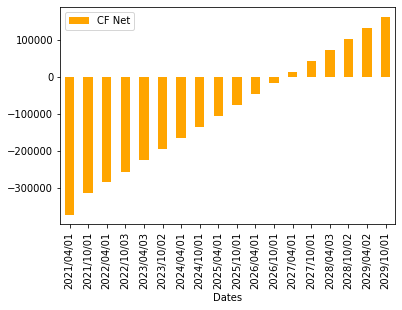

In [19]:
# We can build a cash flow table from the 'cashflows' of the response
cashflows = results.data[0]['Analytic/default/Cashflows']

labels = cashflows['slices']['Pay']['labelsY']
cf_pay = cashflows['slices']['Pay']['values']
cf_rec = cashflows['slices']['Receive']['values']

data ={
    'Dates':[keys for keys, values in labels.items()],
    'CF Pay':[values for keys, values in cf_pay.items()],
    'CF Receive':[values for keys, values in cf_rec.items()],
}

# Create a dataframe and add a 'Net' column
cf_table = pd.DataFrame(data)
cf_table['CF Net'] = cf_table['CF Pay']+cf_table['CF Receive']
cf_table.plot.bar(x='Dates', y='CF Net', color = 'orange')
display(cf_table)
plot.show()

## 3. Historical Cash Flows

### 3.1 Update Fixings for Historical Resets

Given that for our example we have used a dated 10y EUR swap, we would imagine our portfolio to have incurred some impacts to its cash position. These can be illustrated in LUSID by creating transactions that adjust the cash balance.

For historical cash flows, we will need some market data again in order to determine the fixings on our floating leg for past reset dates.

In [20]:
fix_date_2 = datetime(2020, 4, 1, 0, 0, tzinfo=pytz.utc)
fix_date_3 = datetime(2020, 10, 1, 0, 0, tzinfo=pytz.utc)

# def upsert_reset(ccy, start, rate, lineage, marketDataScope
resetSeriesId = models.QuoteSeriesId(
    provider="Lusid",
    price_source=None,
    instrument_id="EUR6M",
    instrument_id_type="RIC",
    quote_type="Rate",
    field="mid"
)
QuoteId1 = models.QuoteId(
    quote_series_id=resetSeriesId,
    effective_at=fix_date_2
)
EUR6m1stQuoteRequest = models.UpsertQuoteRequest(
    quote_id=QuoteId1,
    metric_value=models.MetricValue(
        value=-0.0028, unit="rate"),
    lineage="EUR libor"
)
QuoteId2 = models.QuoteId(
    quote_series_id=resetSeriesId,
    effective_at=fix_date_3)

EUR6m2ndQuoteRequest = models.UpsertQuoteRequest(
quote_id=QuoteId2,
metric_value=models.MetricValue(
    value=-0.0048, unit="rate"),
lineage="EUR libor"
)
    
response = api_factory.build(lusid.api.QuotesApi).upsert_quotes(scope=market_data_scope,
                          request_body={"1":EUR6m1stQuoteRequest,"2":EUR6m2ndQuoteRequest})



if response.failed == {}:
    print("Quotes for Euribor fixings were successfully upserted")
else:
    print("An error occurred with the above upsert_quotes call")

Quotes for Euribor fixings were successfully upserted


In [21]:
historical_cf = {
    'Payment Dates': [fix_date_2, fix_date_3],
    'Receive' : [-70000.0, -120000.0],
    'Pay': [250000.0, 250000.0], 
    }

historical_df = pd.DataFrame(historical_cf)
historical_df['Payment Dates'] = pd.to_datetime(historical_df['Payment Dates'].dt.strftime('%m/%d/%Y %I:%M:%S %p'))
display(historical_df)

,Payment Dates,Receive,Pay
0,2020-04-01,"-70,000.00","250,000.00"
1,2020-10-01,"-120,000.00","250,000.00"


### 3.2 Create Transactions with Properties

Using our EUR006M fixings, we can determine the historical cash flows that would have taken place prior to today's valuation. Within LUSID, these can be stored using separate holding keys, which are a special type of transaction property that allow a user to differentiate between transactions on the same instrument. You can learn more about these type of properties [here](https://support.finbourne.com/how-are-subholding-keys-used-to-capture-different-investment-strategies). 

In our example the property will allow us to distinguish between cash flows that come from the pay/receive legs. Naturally, these could be applied using different property definitions as well, such as relating to a particular broker, custodian, fund accountant, etc.   

In [22]:
# Setup transaction property
domain = "Transaction"
scope = tradingScope
property_code = "LegSide"

try:
    api_factory.build(lusid.api.PropertyDefinitionsApi).create_property_definition(
        create_property_definition_request=lusid.models.CreatePropertyDefinitionRequest(
            domain = domain,
            scope = scope,
            code = property_code,
            value_required = None,
            display_name = "Pay/Receive Cash FLow Key",
            data_type_id = lusid.ResourceId(scope="system", code="string"),
            life_time = None
        )
    )

except lusid.exceptions.ApiException as e:
    print(json.loads(e.body)["title"])

Error creating Property Definition 'Transaction/Finbourne-Examples/LegSide' because it already exists.


In [23]:
historical_cf = {
    'Payment Dates': [fix_date_2, fix_date_3],
    'Receive' : [-70000.0, -120000.0],
    'Pay': [250000.0, 250000.0], 
    }

historical_df = pd.DataFrame(historical_cf)
historical_df['Payment Dates'] = pd.to_datetime(historical_df['Payment Dates'].dt.strftime('%m/%d/%Y %I:%M:%S %p'))
display(historical_df)

,Payment Dates,Receive,Pay
0,2020-04-01,"-70,000.00","250,000.00"
1,2020-10-01,"-120,000.00","250,000.00"


In [24]:
# Book cash transactions - 1st Payment Date
cashTransaction1 = models.TransactionRequest(
    transaction_id="TXN002",
    type="FundsOut",
    instrument_identifiers={"Instrument/default/Currency":"EUR"},
    transaction_date=fix_date_2.isoformat(),
    settlement_date=fix_date_2.isoformat(),
    units=historical_cf['Pay'][0],
    transaction_price=models.TransactionPrice(price=1,type="Price"),
    total_consideration=models.CurrencyAndAmount(amount=1,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR",
    properties = {f"Transaction/{tradingScope}/{property_code}" : lusid.PerpetualProperty(
        key = f"Transaction/{tradingScope}/{property_code}",
        value = lusid.PropertyValue(label_value = "Pay")
    )             
                 }
)

cashTransaction2 = models.TransactionRequest(
    transaction_id="TXN003",
    type="FundsIn",
    instrument_identifiers={"Instrument/default/Currency":"EUR"},
    transaction_date=fix_date_2.isoformat(),
    settlement_date=fix_date_2.isoformat(),
    units=historical_cf['Receive'][0],
    transaction_price=models.TransactionPrice(price=1,type="Price"),
    total_consideration=models.CurrencyAndAmount(amount=1,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR",
    properties = {f"Transaction/{tradingScope}/{property_code}" : lusid.PerpetualProperty(
        key = f"Transaction/{tradingScope}/{property_code}",
        value = lusid.PropertyValue(label_value = "Receive")
    )             
                 }
)


# Book cash transactions - 2nd Payment Date
cashTransaction3 = models.TransactionRequest(
    transaction_id="TXN004",
    type="FundsOut",
    instrument_identifiers={"Instrument/default/Currency":"EUR"},
    transaction_date=fix_date_3.isoformat(),
    settlement_date=fix_date_3.isoformat(),
    units=historical_cf['Pay'][1],
    transaction_price=models.TransactionPrice(price=1,type="Price"),
    total_consideration=models.CurrencyAndAmount(amount=1,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR",
    properties = {f"Transaction/{tradingScope}/{property_code}" : lusid.PerpetualProperty(
        key = f"Transaction/{tradingScope}/{property_code}",
        value = lusid.PropertyValue(label_value = "Pay")
    )             
                 }
)

cashTransaction4 = models.TransactionRequest(
    transaction_id="TXN005",
    type="FundsIn",
    instrument_identifiers={"Instrument/default/Currency":"EUR"},
    transaction_date=fix_date_3.isoformat(),
    settlement_date=fix_date_3.isoformat(),
    units=historical_cf['Receive'][1],
    transaction_price=models.TransactionPrice(price=1,type="Price"),
    total_consideration=models.CurrencyAndAmount(amount=1,currency="EUR"),
    exchange_rate=1,
    transaction_currency="EUR",
    properties = {f"Transaction/{tradingScope}/{property_code}" : lusid.PerpetualProperty(
        key = f"Transaction/{tradingScope}/{property_code}",
        value = lusid.PropertyValue(label_value = "Receive")
    )             
                 }
)


response = api_factory.build(lusid.api.TransactionPortfoliosApi).upsert_transactions(scope=tradingScope,
                                                    code=tradingCode,
                                                    transaction_request=[
                                                        cashTransaction1, 
                                                        cashTransaction2, 
                                                        cashTransaction3, 
                                                        cashTransaction4
                                                    ])

### 3.3 Aggregate Cash Flows

With the transactions updated into the portfolio, we can now query the holdings which will include our updated total cash balance. Given the negative rates on the floating leg, we can see that the original EUR 1MM is reduced significantly as a result of this. In order to run the query, we use the `TransactionPortfoliosApi`, which is the required API to interact with a [Transaction Porftolio](#https://support.finbourne.com/what-is-a-transaction-portfolio). In this case we can use the [**get_holdings**](https://www.lusid.com/docs/api/#operation/GetHoldings) call with a reference to our portfolio's scope and code. 

In [25]:
response = api_factory.build(lusid.api.TransactionPortfoliosApi).get_holdings(
    scope=tradingScope, 
    code=tradingCode, 
    property_keys=["Instrument/default/Name"], 
 
)
df_balance = pd.DataFrame({'Current Balance' : [response.values[1].settled_units]})
df_balance

,Current Balance
0,"309,999.00"


Using the previously set transaction properties, we can now query these to distinguish between different types of cash inflows and outfows. We should now be able to separate pay/receive-leg cash flows. Without the transaction key-value pairs, this might be difficult in a larger book of swaps, given that the receiving cash flows are negative.

Using the same API, we can run the [**get_transactions**](https://www.lusid.com/docs/api/#operation/GetTransactions) call for the scope of our portfolio. Additionally, since we are looking to separate based on values of the transaction property we can add a property filter to the call which results in the following to datasets.

In [26]:
response_pay = api_factory.build(lusid.api.TransactionPortfoliosApi).get_transactions(scope = tradingScope, 
                                                                                  code = tradingCode,
                                                                                  filter = f"properties.Transaction/{tradingScope}/{property_code} eq 'Pay'")

response_rec = api_factory.build(lusid.api.TransactionPortfoliosApi).get_transactions(scope = tradingScope, 
                                                                                  code = tradingCode,
                                                                                  filter = f"properties.Transaction/{tradingScope}/{property_code} eq 'Receive'")

df_pay = lusid_response_to_data_frame(response_pay.values)
df_rec = lusid_response_to_data_frame(response_rec.values)

display(df_pay)
display(df_rec)

,transaction_id,type,instrument_identifiers.Instrument/default/Currency,instrument_uid,transaction_date,settlement_date,units,transaction_price.price,transaction_price.type,total_consideration.amount,total_consideration.currency,exchange_rate,transaction_currency,properties.Transaction/Finbourne-Examples/LegSide.key,properties.Transaction/Finbourne-Examples/LegSide.value.label_value
0,TXN002,FundsOut,EUR,CCY_EUR,2020-04-01 00:00:00+00:00,2020-04-01 00:00:00+00:00,"250,000.00",1.00,Price,1.00,EUR,1.00,EUR,Transaction/Finbourne-Examples/LegSide,Pay
1,TXN004,FundsOut,EUR,CCY_EUR,2020-10-01 00:00:00+00:00,2020-10-01 00:00:00+00:00,"250,000.00",1.00,Price,1.00,EUR,1.00,EUR,Transaction/Finbourne-Examples/LegSide,Pay


,transaction_id,type,instrument_identifiers.Instrument/default/Currency,instrument_uid,transaction_date,settlement_date,units,transaction_price.price,transaction_price.type,total_consideration.amount,total_consideration.currency,exchange_rate,transaction_currency,properties.Transaction/Finbourne-Examples/LegSide.key,properties.Transaction/Finbourne-Examples/LegSide.value.label_value
0,TXN003,FundsIn,EUR,CCY_EUR,2020-04-01 00:00:00+00:00,2020-04-01 00:00:00+00:00,"-70,000.00",1.00,Price,1.00,EUR,1.00,EUR,Transaction/Finbourne-Examples/LegSide,Receive
1,TXN005,FundsIn,EUR,CCY_EUR,2020-10-01 00:00:00+00:00,2020-10-01 00:00:00+00:00,"-120,000.00",1.00,Price,1.00,EUR,1.00,EUR,Transaction/Finbourne-Examples/LegSide,Receive
